In [21]:
# OPEN IN GOOGLE COLLAB!!!!!
devtools::install_github("ankargren/mfbvar")
library(tidyverse)
library(mfbvar)
library(imputeTS)
library(Rmisc)

also installing the dependencies 'curl', 'openssl', 'httr2', 'htmltools', 'sass', 'vctrs', 'gert', 'gh', 'bslib', 'callr', 'purrr', 'brio', 'digest', 'jsonlite', 'magrittr', 'processx', 'ps', 'waldo', 'usethis', 'cli', 'fs', 'lifecycle', 'pkgdown', 'pkgload', 'rcmdcheck', 'rlang', 'roxygen2', 'sessioninfo', 'testthat'

Warning message:
"unable to access index for repository https://cran.r-project.org/bin/windows/contrib/3.6:
  не могу открыть URL 'https://cran.r-project.org/bin/windows/contrib/3.6/PACKAGES'"Packages which are only available in source form, and may need
  compilation of C/C++/Fortran: 'curl' 'openssl' 'htmltools' 'sass'
  'vctrs' 'gert' 'purrr' 'brio' 'digest' 'jsonlite' 'magrittr'
  'processx' 'ps' 'cli' 'fs' 'rlang' 'roxygen2' 'testthat'


  These will not be installed


installing the source packages 'httr2', 'gh', 'bslib', 'callr', 'waldo', 'usethis', 'lifecycle', 'pkgdown', 'pkgload', 'rcmdcheck', 'sessioninfo', 'devtools'

Warning message in install.packages("devtools"):
"installation of package 'callr' had non-zero exit status"Warning message in install.packages("devtools"):
"installation of package 'waldo' had non-zero exit status"Warning message in install.packages("devtools"):
"installation of package 'lifecycle' had non-zero exit status"Warning message in install.packages("devtools"):
"installation of package 'pkgload' had non-zero exit status"Warning message in install.packages("devtools"):
"installation of package 'sessioninfo' had non-zero exit status"Warning message in install.packages("devtools"):
"installation of package 'httr2' had non-zero exit status"Warning message in install.packages("devtools"):
"installation of package 'bslib' had non-zero exit status"Warning message in install.packages("devtools"):
"installation of package 'rcmdc

ERROR: Error in library(devtools): there is no package called 'devtools'


In [23]:
install.packages("jupytext")
library(jupytext)

Warning message:
"package 'jupytext' is not available (for R version 3.6.1)"Warning message:
"unable to access index for repository https://cran.r-project.org/bin/windows/contrib/3.6:
  не могу открыть URL 'https://cran.r-project.org/bin/windows/contrib/3.6/PACKAGES'"

ERROR: Error in library(jupytext): there is no package called 'jupytext'


In [8]:
# helper function, generate lagged datasets for testing on vintages
gen_lagged_data <- function (metadata, data, last_date, lag) {
  # only go up to the last date
  lagged_data <- data %>% 
    dplyr::filter(date <= last_date)
  
  for (col in colnames(lagged_data)[2:length(colnames(lagged_data))]) {
    pub_lag <- metadata %>% 
      dplyr::filter(series == col) %>% 
      select(months_lag) %>% 
      pull()
    
    # go back as far as needed for the pub_lag of the variable, then + the lag (so -2 for 2 months back)
    condition <- (nrow(lagged_data) - pub_lag + lag)
    # only input NA if the lag is less than the latest row in the data
    if (condition <= nrow(lagged_data)) {
      lagged_data[condition:nrow(lagged_data), col] <- NA
    } 
  }
  lagged_data <- lagged_data %>% 
    dplyr::filter(!is.na(date))
  return (lagged_data)
}

# Data set up

In [10]:
# full data read
metadata <- read_csv("../data/russian_meta_data.csv")
data <- read_csv("../data/russian_data_tf.csv") %>%
  arrange(date)

target_variable <- "gdp"

# which lags to assess
lags <- -2:2

# dates for 3 testing periods
train_start_date = "2004-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2023-12-01"

# train and test datasets
train <- data %>%
    filter(date >= train_start_date, date <= train_end_date) %>%
    # the nowcastDFM library only works with dataframe, may get errors in estimation if you use tibbles
    data.frame()
test <- data %>%
    filter(date >= train_start_date, date <= test_end_date) %>% # let test set data begin from training begin, data lag/time series for test sets can go back into the training data
    data.frame()

# replace any infinites with NA
for (col in colnames(train)) {
    if (sum(is.infinite(train[,col])) > 0) {
      train[is.infinite(train[,col]), col] <- NA 
    }
}

for (col in colnames(test)) {
    if (sum(is.infinite(test[,col])) > 0) {
      test[is.infinite(test[,col]), col] <- NA 
    }
}

Parsed with column specification:
cols(
  series = col_character(),
  name = col_character(),
  freq = col_character(),
  block_g = col_double(),
  block_s = col_double(),
  block_r = col_double(),
  block_l = col_double(),
  months_lag = col_double()
)
Parsed with column specification:
cols(
  date = col_date(format = ""),
  ibved = col_double(),
  cpi = col_double(),
  oil_price = col_double(),
  rate = col_double(),
  exchange_rate = col_double(),
  m2 = col_double(),
  us_cpi = col_double(),
  PMI = col_double(),
  unemployment = col_double(),
  gdp = col_double()
)


Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [11]:
tail(data)

date       ibved        cpi         oil_price    rate       exchange_rate
1 2023-09-01  0.012538512 0.009837227  0.113808008 0.19212243  0.024502939 
2 2023-10-01 -0.003476467 0.007527797 -0.050173893 0.05653588  0.018605592 
3 2023-11-01 -0.002770268 0.008602941 -0.054757935 0.13805592 -0.071001335 
4 2023-12-01  0.009220673 0.004878194 -0.016119157 0.03167405  0.014419452 
5 2024-01-01 -0.006672448 0.005014627 -0.004557104 0.03391829 -0.000310218 
6 2024-02-01           NA 0.004907060  0.022936019 0.00000000  0.011463748 
  m2          us_cpi      PMI         unemployment  gdp       
1 0.015143035 0.006172840 -0.02146691 -0.0138485379 0.01104163
2 0.007442627 0.006134969 -0.02010969 -0.0425652593         NA
3 0.016074268 0.000000000 -0.02238806 -0.0004864564         NA
4 0.013206326 0.000000000  0.06297710  0.0177134539 0.01541894
5 0.014696643 0.006097561 -0.01077199 -0.0382772713         NA
6 0.017927246 0.000000000 -0.05263158            NA         NA

# Training the model
Because of how Bayesian VAR models are estimated, similar to ARMA models, there is no model training per se, the model is fitted and n-step ahead forecasts are generated at each data vintage in the testing set. This gives the model a bit more training information than the other methodologies, but there is no workaround I am aware of to to generate estimates on the test set with information exclusively from the training set.

# Testing the model on artificial data vintages

In [12]:
# dates in the test set (original)
dates <- seq(as.Date(test_start_date), as.Date(test_end_date), by="month") %>% 
      .[(substr(., 6, 7) %in% c("03", "06", "09", "12"))]

In [ ]:
# dates in the test set (my)
dates <- seq(as.Date(test_start_date), as.Date(test_end_date), by="month")[3:] %>% 
      .[(substr(., 6, 7) %in% c("03", "06", "09", "12"))]

In [17]:
# dataframe for predictions
pred_dict <- data.frame(date = dates)
for (lag in lags) {
  pred_dict[,as.character(lag)] <- NA
}
# looping through test dates
for (date in as.character(dates)) {
  for (lag in lags) {
    lagged_data <- gen_lagged_data(metadata, test, date, lag) %>% 
      data.frame
    # make sure actual value not in there
    lagged_data[lagged_data$date == date, target_variable] <- NA
      
    # preserving NA structure at end, but filling earlier rows with mean to be able to estimate
    lagged_data[1:(round(nrow(lagged_data) * 0.9, 0)),] <- na_mean(lagged_data[1:(round(nrow(lagged_data) * 0.9, 0)),])
    lagged_data <- lagged_data[rowSums(is.na(lagged_data)) != ncol(lagged_data)-1, ] # drop end rows with only nas
    
    # converting to data format for mfbvar
    mf_test <- list()
    for (col in colnames(train)[2:length(colnames(train))]) {
        # get data frequency
        freq <- metadata %>% 
          filter(series == !!col) %>% 
          select(freq) %>% 
          pull()
        if (freq == "q") {
          freq <- 4
          tmp_series <- lagged_data %>% 
            filter(substr(date, 6, 7) %in% c("03", "06", "09", "12")) %>% 
            select(!!col) %>%
            slice(2:n()) %>% # first row is all NAs, so drop
            pull()
        } else {
          freq <- 12
          tmp_series <- lagged_data %>%
            select(!!col) %>% 
            slice(2:n()) %>%
            pull()
        }
        # convert data to correct time series format, set start date to correct start date of your data
        tmp_ts <- ts(tmp_series, start = c(1947,2), frequency = freq)
        mf_test[[col]] <- tmp_ts
    }
    
    # reorder the list to have quarterly variables, `ulcnfb` and `a261rx1q020sbea`, come last. Necessary for mfbvar library
    mf_test <- list(
      payems=mf_test$payems,
      cpiaucsl=mf_test$cpiaucsl,
      unrate=mf_test$unrate,
      houst=mf_test$houst,
      indpro=mf_test$indpro,
      dspic96=mf_test$dspic96,
      cpilfesl=mf_test$cpilfesl,
      pcepilfe=mf_test$pcepilfe,
      pcepi=mf_test$pcepi,
      permit=mf_test$permit,
      ulcnfb=mf_test$ulcnfb,
      a261rx1q020sbea=mf_test$a261rx1q020sbea,
      gdpc1=mf_test$gdpc1
    )
      
    # actual bayesian var estimation
    prior <- set_prior(Y = mf_test, n_lags = 4, n_reps = 100)
    c_interval <- t(sapply(mf_test, CI, ci=0.95))
    prior_intervals <- c_interval[,c("upper","lower")]
    moments <- interval_to_moments(prior_intervals)
    prior <- update_prior(prior, d="intercept", prior_psi_mean = moments$prior_psi_mean,  prior_psi_Omega = moments$prior_psi_Omega)
    prior <- update_prior(prior, n_fcst = 12)

    model <- estimate_mfbvar(prior, prior = "minn", variance = "iw")

    prediction <- predict(model, pred_bands = NULL) %>% 
        filter(variable == target_variable, fcst_date == date) %>% 
        select(fcst) %>% 
        pull() %>% 
        mean()
    
    pred_dict[pred_dict$date == date, as.character(lag)] <- prediction
  }
}

ERROR: Error in na_mean(lagged_data[1:(round(nrow(lagged_data) * 0.9, 0)), ]): не могу найти функцию "na_mean"


# Assess and visualize model performance

In [7]:
actuals <- test %>%
    filter(date >= test_start_date) %>%
    select(!!target_variable) %>%
    filter(!is.na(!!sym(target_variable))) %>%
    pull()

In [8]:
performance <- data.frame(Vintage = numeric(), RMSE = numeric())
for (lag in lags) {
    tmp = data.frame(
        Vintage = lag,
        RMSE = sqrt(mean((actuals - pred_dict[,as.character(lag)])**2))
    )
    performance = rbind(performance, tmp)
}
round(performance, 4)

Vintage RMSE  
1 -2      0.0050
2 -1      0.0048
3  0      0.0045
4  1      0.0040
5  2      0.0043

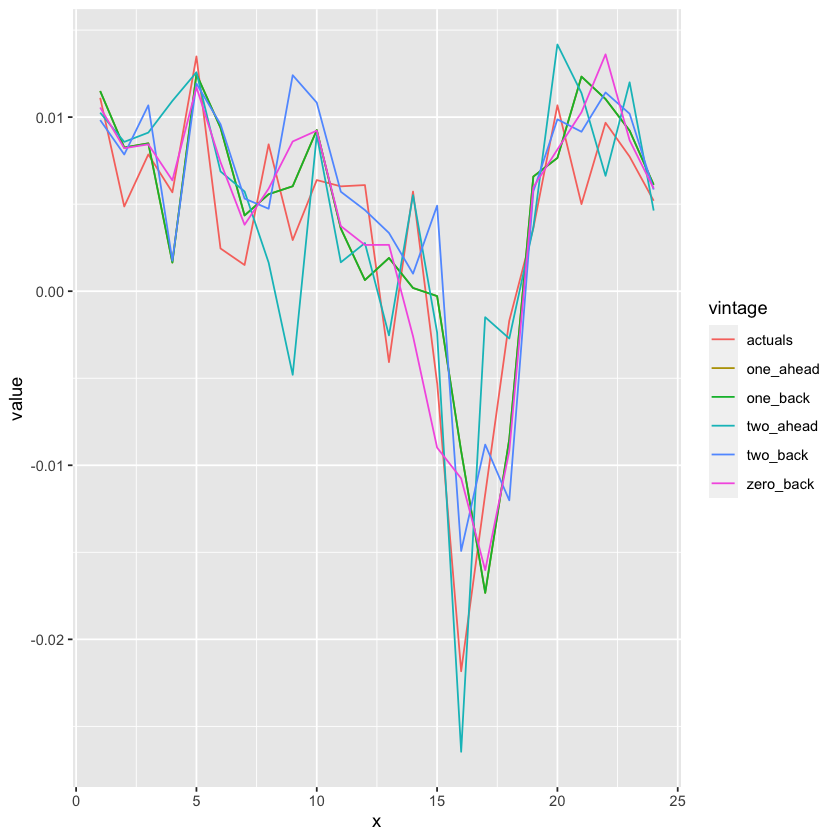

In [11]:
# plot of predictions vs actuals
p <- tibble(
    actuals = actuals,
    two_back = pred_dict[, "-2"], 
    one_back = pred_dict[, "-1"], 
    zero_back = pred_dict[, "0"],
    one_ahead = pred_dict[, "-1"],
    two_ahead = pred_dict[, "2"]
) %>%
    dplyr::mutate(x = 1:n()) %>%
    gather(vintage, value, -x) %>%
    ggplot() + 
    aes(x=x, y=value, color=vintage) + 
    geom_line()
p

# Final model usage / getting predictions on new data
Say model selection is finished and the model is to now be used, i.e. used to get predictions on new data.

In [14]:
# the test data ends 2010-12-01, let's say we wanted to predict 2011-03-01
new_data = test

# preserving NA structure at end, but filling earlier rows with mean to be able to estimate
new_data[1:(round(nrow(new_data) * 0.9, 0)),] <- na_mean(new_data[1:(round(nrow(new_data) * 0.9, 0)),])
new_data <- lagged_data[rowSums(is.na(new_data)) != ncol(new_data)-1, ] # drop end rows with only nas

# converting to data format for mfbvar
mf_test <- list()
for (col in colnames(train)[2:length(colnames(train))]) {
    # get data frequency
    freq <- metadata %>% 
      filter(series == !!col) %>% 
      select(freq) %>% 
      pull()
    if (freq == "q") {
      freq <- 4
      tmp_series <- new_data %>% 
        filter(substr(date, 6, 7) %in% c("03", "06", "09", "12")) %>% 
        select(!!col) %>%
        slice(2:n()) %>% # first row is all NAs, so drop
        pull()
    } else {
      freq <- 12
      tmp_series <- new_data %>%
        select(!!col) %>% 
        slice(2:n()) %>%
        pull()
    }
    # convert data to correct time series format, set start date to correct start date of your data
    tmp_ts <- ts(tmp_series, start = c(1947,2), frequency = freq)
    mf_test[[col]] <- tmp_ts
}

# reorder the list to have quarterly variables, `ulcnfb` and `a261rx1q020sbea`, come last. Necessary for mfbvar library
mf_test <- list(
  payems=mf_test$payems,
  cpiaucsl=mf_test$cpiaucsl,
  unrate=mf_test$unrate,
  houst=mf_test$houst,
  indpro=mf_test$indpro,
  dspic96=mf_test$dspic96,
  cpilfesl=mf_test$cpilfesl,
  pcepilfe=mf_test$pcepilfe,
  pcepi=mf_test$pcepi,
  permit=mf_test$permit,
  ulcnfb=mf_test$ulcnfb,
  a261rx1q020sbea=mf_test$a261rx1q020sbea,
  gdpc1=mf_test$gdpc1
)

In [16]:
# actual bayesian var estimation
prior <- set_prior(Y = mf_test, n_lags = 4, n_reps = 100)
c_interval <- t(sapply(mf_test, CI, ci=0.95))
prior_intervals <- c_interval[,c("upper","lower")]
moments <- interval_to_moments(prior_intervals)
prior <- update_prior(prior, d="intercept", prior_psi_mean = moments$prior_psi_mean,  prior_psi_Omega = moments$prior_psi_Omega)
prior <- update_prior(prior, n_fcst = 12)

model <- estimate_mfbvar(prior, prior = "minn", variance = "iw")

predict(model, pred_bands = NULL) %>% 
    filter(variable == target_variable, fcst_date == "2011-03-01") %>% 
    select(fcst) %>% 
    pull() %>% 
    mean()

[1] 0.01116272